# Rotman Data Science Competition

Exploratory Data Analysis


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 0. Quick Competition Data Preview

In [2]:
def load_competition_data() -> pd.DataFrame:
    DATA_PATH = "data/mma_mart.csv"
    data = pd.read_csv(DATA_PATH)
    return data

In [3]:
mma_data = load_competition_data()
mma_data.head()

,order_id,product_id,product_name,aisle_id,aisle,department_id,department
0,1,49302,Bulgarian Yogurt,120,yogurt,16,dairy eggs
1,1,11109,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,other creams cheeses,16,dairy eggs
2,1,10246,Organic Celery Hearts,83,fresh vegetables,4,produce
3,1,49683,Cucumber Kirby,83,fresh vegetables,4,produce
4,1,43633,Lightly Smoked Sardines in Olive Oil,95,canned meat seafood,15,canned goods


In [6]:
mma_data.shape

(987259, 7)

In [7]:
mma_data.nunique()

order_id         97833
product_id       35070
product_name     35070
aisle_id           134
aisle              134
department_id       21
department          21
dtype: int64

In [11]:
mma_data.groupby("department")["department"].count()

department
alcohol              4580
babies              12872
bakery              35806
beverages           81923
breakfast           21585
bulk                 1087
canned goods        32486
dairy eggs         164468
deli                32008
dry goods pasta     26096
frozen              68202
household           22445
international        8248
meat seafood        21588
missing              2289
other                1097
pantry              56681
personal care       13773
pets                 3157
produce            288775
snacks              88093
Name: department, dtype: int64

In [10]:
mma_data.groupby("aisle")["aisle"].count()

aisle
air fresheners candles             592
asian foods                       5229
baby accessories                   242
baby bath body care                232
baby food formula                11660
                                 ...  
trash bags liners                 1051
vitamins supplements              1410
water seltzer sparkling water    25354
white wines                        916
yogurt                           43857
Name: aisle, Length: 134, dtype: int64

## 1. Competition Data Exploratory Analysis
### 1.1 Identifying Trends Over Time
#### a) Identifying Trends in Department Sales

In [57]:
# Get relevant data for analysis of trends in department sales
dep_analysis = mma_data.loc[:, ["order_id", "department"]]

# Get department names
departments = dep_analysis["department"].unique()

dep_analysis.head()

,order_id,department
0,1,dairy eggs
1,1,dairy eggs
2,1,produce
3,1,produce
4,1,canned goods


In [58]:
# Make table of order ids to departments
order_id_by_department = dep_analysis.pivot_table(index="order_id", columns="department", aggfunc="size")
order_id_by_department.fillna(0, inplace=True)
order_id_by_department.head()

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
order_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
4,0.0,0.0,1.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,2.0,...,3.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,7.0,4.0


Turn order ids into days. Currently using the crude method of assuming a constant number of orders per day.

In [88]:
ORDERS_PER_DAY = 500
# Edit pivot table to make index days
order_id_by_department["t"] = np.ceil(order_id_by_department.index / ORDERS_PER_DAY)
time_to_dep_sales = order_id_by_department.groupby("t").sum()
time_to_dep_sales.head()

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
t,,,,,,,,,,,,,,,,,,,,,
1.0,14.0,69.0,165.0,407.0,110.0,5.0,178.0,808.0,168.0,119.0,...,133.0,34.0,112.0,5.0,7.0,283.0,67.0,14.0,1420.0,410.0
2.0,13.0,63.0,182.0,398.0,125.0,1.0,177.0,802.0,151.0,134.0,...,121.0,54.0,117.0,10.0,8.0,316.0,60.0,13.0,1501.0,450.0
3.0,16.0,74.0,168.0,382.0,107.0,8.0,184.0,839.0,157.0,115.0,...,103.0,39.0,103.0,8.0,6.0,285.0,63.0,8.0,1437.0,386.0
4.0,32.0,71.0,196.0,377.0,91.0,10.0,153.0,790.0,165.0,109.0,...,122.0,36.0,120.0,16.0,5.0,306.0,90.0,14.0,1421.0,377.0
5.0,14.0,73.0,214.0,418.0,132.0,7.0,189.0,895.0,182.0,127.0,...,102.0,41.0,101.0,2.0,6.0,269.0,63.0,18.0,1399.0,448.0


Plot figures of department sales over time, with a different line for each department

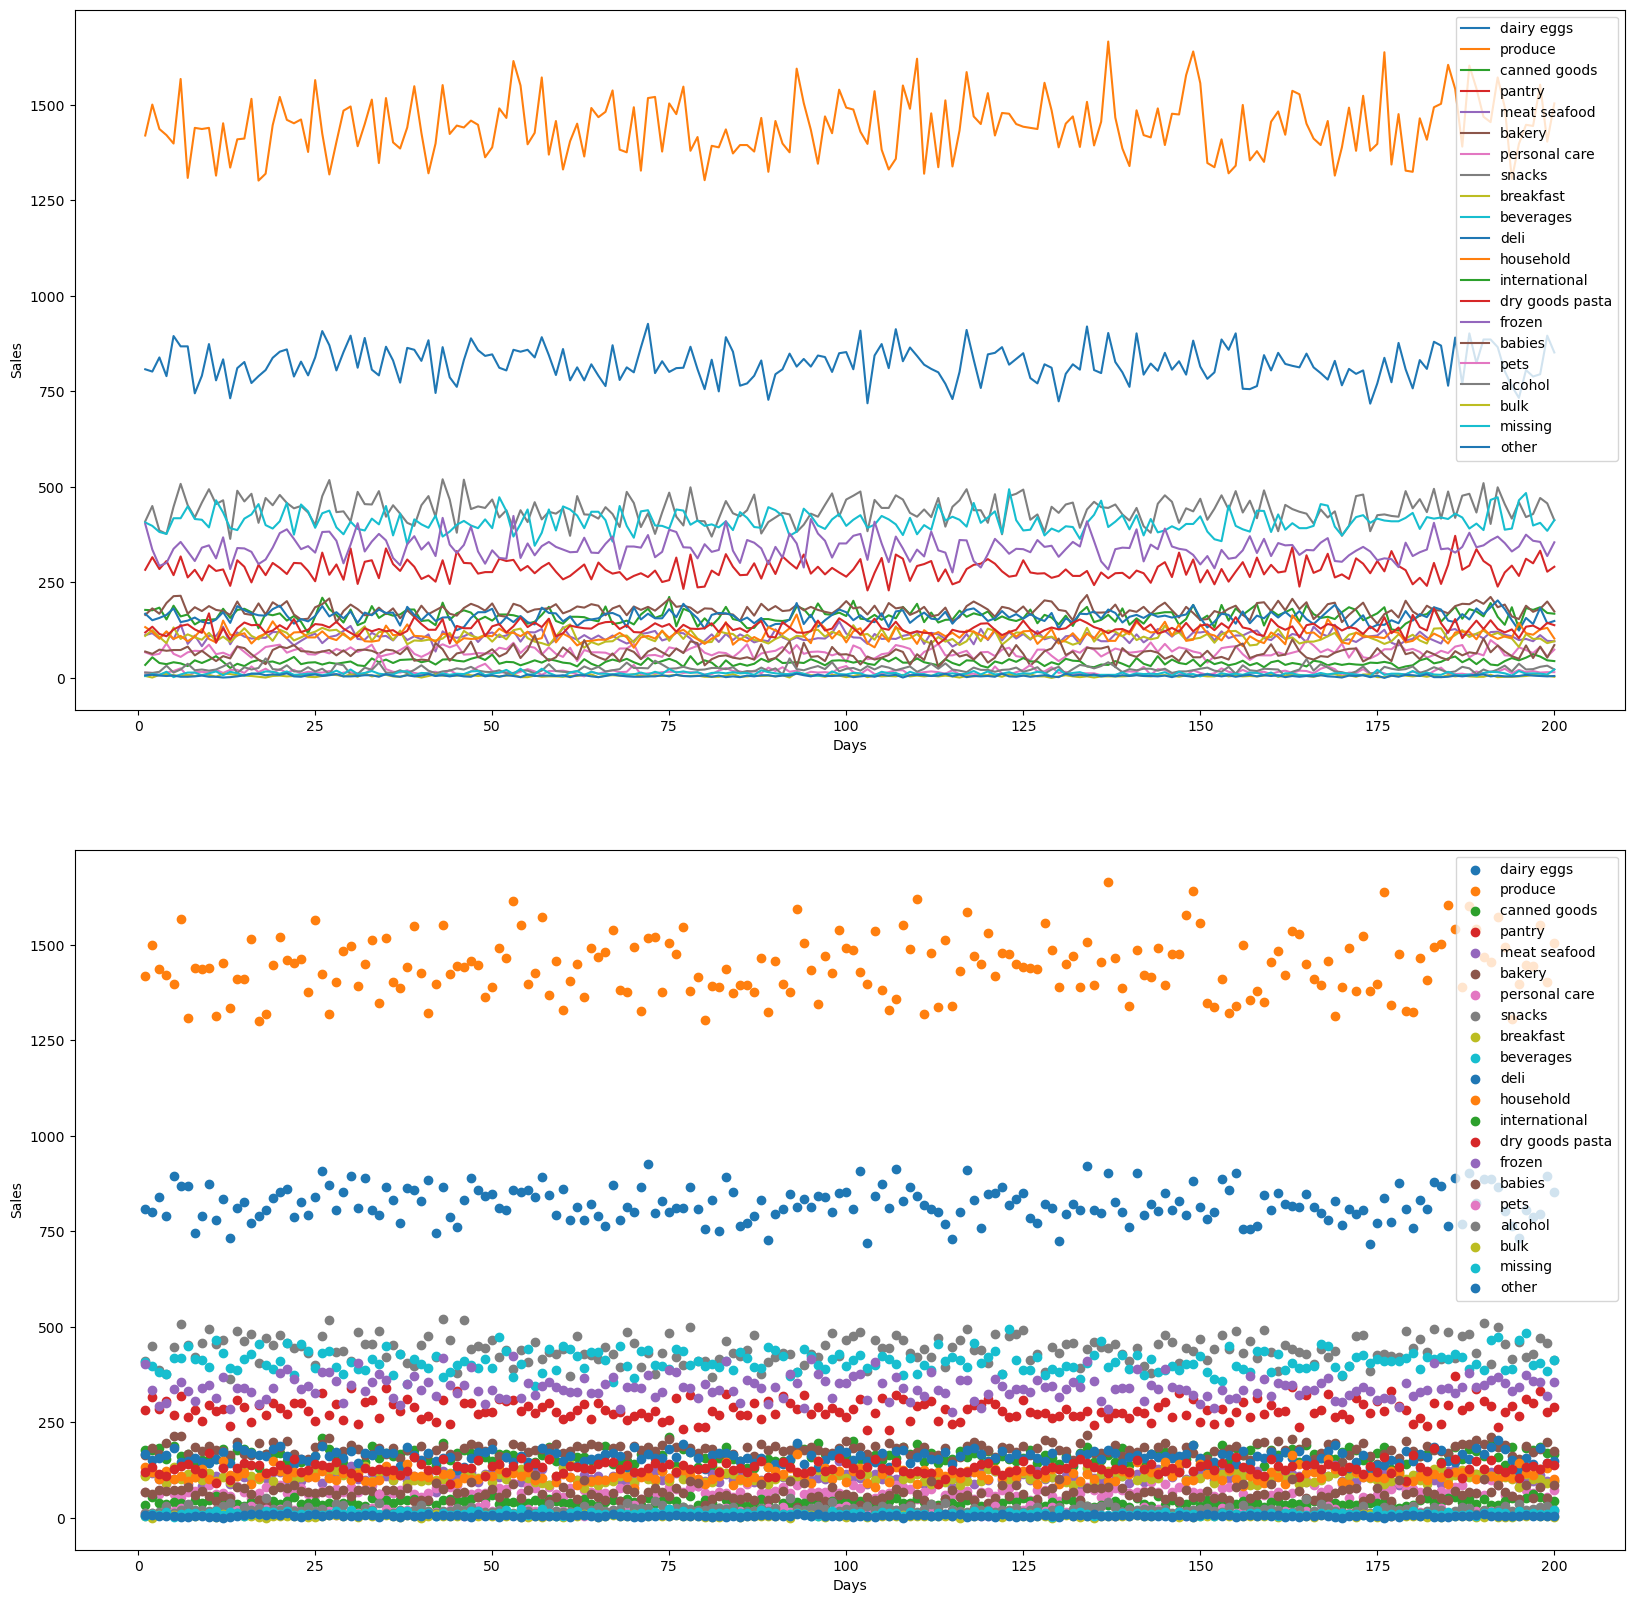

In [92]:
# Plot figures of department sales over time, with a different line for each department
fig, axes = plt.subplots(nrows=2, figsize=(20, 20))

# Set x and y labels
axes[0].set(xlabel="Days", ylabel="Sales")
axes[1].set(xlabel="Days", ylabel="Sales")

# Plot figures
for dep in departments:
    axes[0].plot(time_to_dep_sales.index, time_to_dep_sales[dep], label=dep)
    axes[1].scatter(time_to_dep_sales.index, time_to_dep_sales[dep], label=dep)

# Add legend
axes[0].legend()
axes[1].legend()

plt.show()

Examine departments with less sales by plotting them on a separate graph

In [110]:
time_to_dep_sales.sort_values(axis=1, by=10.0, inplace=True)
time_to_dep_sales.head()

department,other,bulk,missing,pets,alcohol,international,babies,personal care,household,meat seafood,...,deli,canned goods,dry goods pasta,bakery,pantry,frozen,beverages,snacks,dairy eggs,produce
t,,,,,,,,,,,,,,,,,,,,,
1.0,7.0,5.0,5.0,14.0,14.0,34.0,69.0,67.0,133.0,112.0,...,168.0,178.0,119.0,165.0,283.0,403.0,407.0,410.0,808.0,1420.0
2.0,8.0,1.0,10.0,13.0,13.0,54.0,63.0,60.0,121.0,117.0,...,151.0,177.0,134.0,182.0,316.0,336.0,398.0,450.0,802.0,1501.0
3.0,6.0,8.0,8.0,8.0,16.0,39.0,74.0,63.0,103.0,103.0,...,157.0,184.0,115.0,168.0,285.0,293.0,382.0,386.0,839.0,1437.0
4.0,5.0,10.0,16.0,14.0,32.0,36.0,71.0,90.0,122.0,120.0,...,165.0,153.0,109.0,196.0,306.0,301.0,377.0,377.0,790.0,1421.0
5.0,6.0,7.0,2.0,18.0,14.0,41.0,73.0,63.0,102.0,101.0,...,182.0,189.0,127.0,214.0,269.0,338.0,418.0,448.0,895.0,1399.0


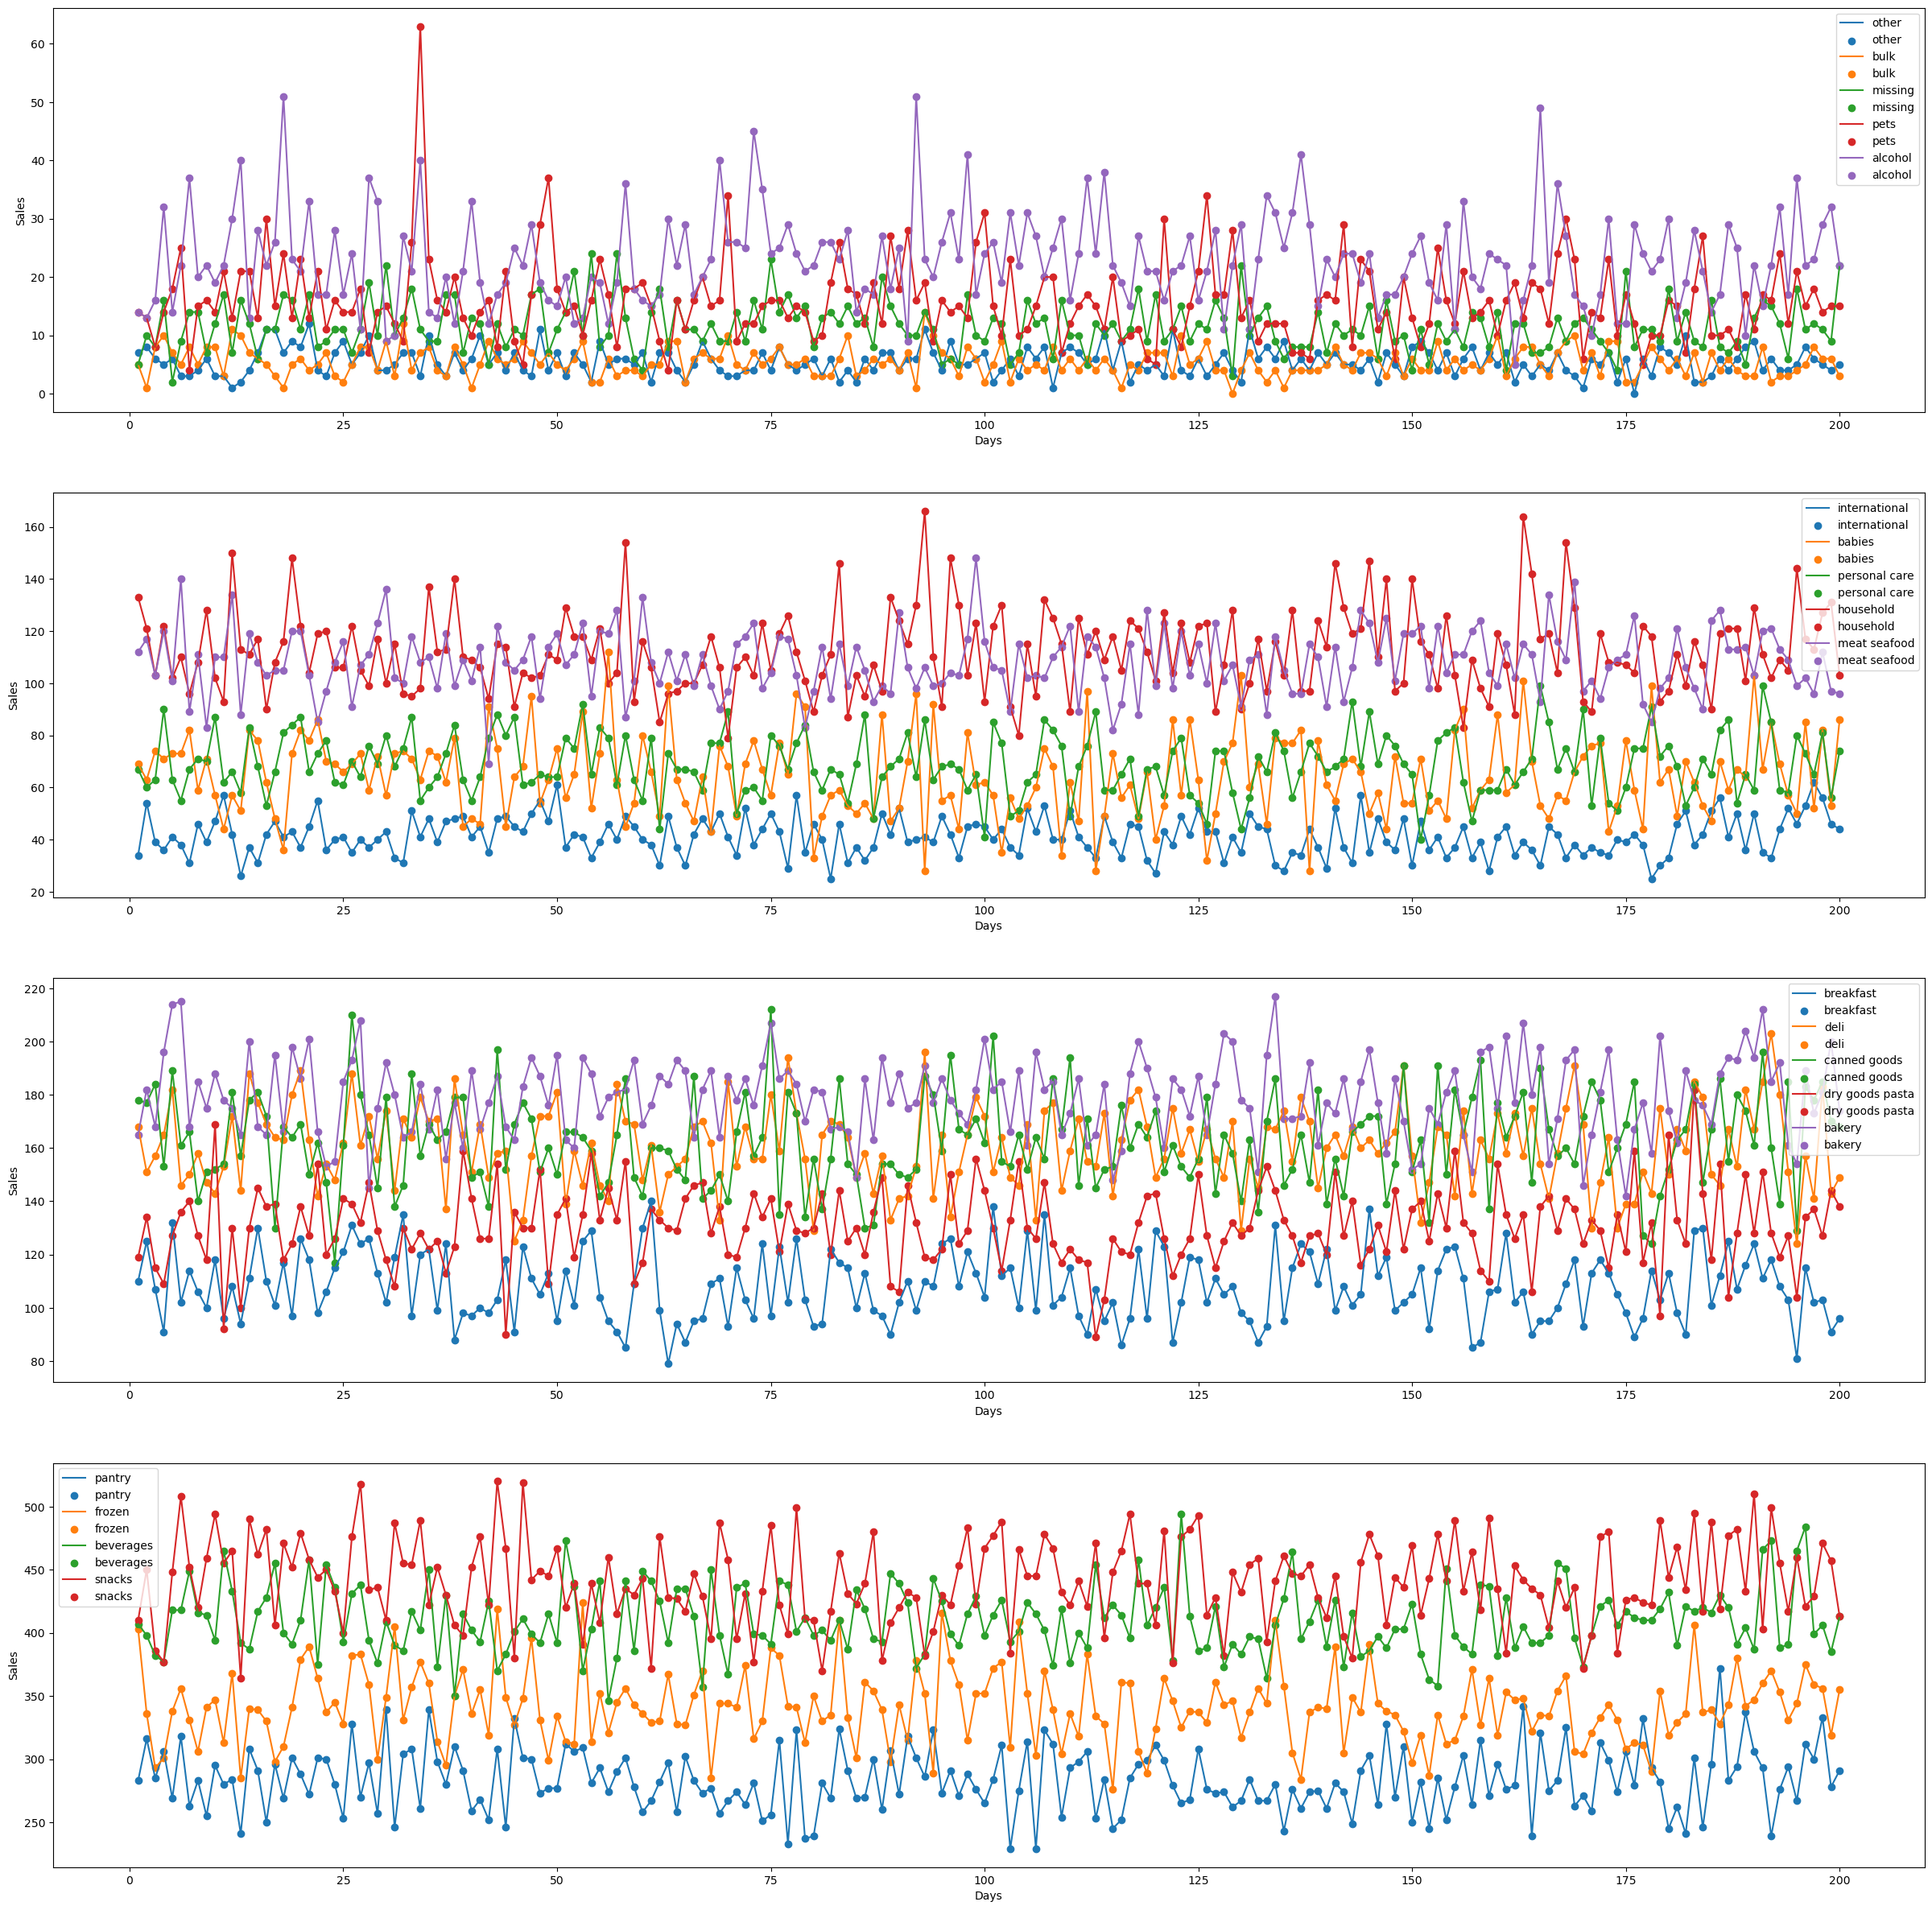

In [115]:
# Plot figures of department sales over time but with smaller departments on different graph
fig, axes = plt.subplots(nrows=4, figsize=(3 * 10, 3 * 10))

# Set x and y labels
for ax in axes:
    ax.set(xlabel="Days", ylabel="Sales")

# Plot figures
sorted_deps = time_to_dep_sales.columns[:-2]
for dep_id in range(len(sorted_deps)):
    dep = sorted_deps[dep_id]
    if dep_id < len(sorted_deps) / 4:
        ax = axes[0]
    elif dep_id < len(sorted_deps) / 2:
        ax = axes[1]
    elif dep_id < 3 * len(sorted_deps) / 4:
        ax = axes[2]
    else:
        ax = axes[3]
    ax.plot(time_to_dep_sales.index, time_to_dep_sales[dep], label=dep)
    ax.scatter(time_to_dep_sales.index, time_to_dep_sales[dep], label=dep)
# Add legends
for ax in axes:
    ax.legend()

plt.show()

## 2. Kaggle Data Analysis

In [ ]:
load_kaggle_data()

raw_data.head()

## 1. Extracting Time Information
### 1.1) Identifying Seasons Using Ice Cream Sales

Identify ice cream isle number

In [ ]:
aisles_data[aisles_data["aisle"] == "ice cream ice"]

Trim products to contain just ice cream

In [ ]:
ice_cream_products = products[products["aisle_id"] == 37]
ice_cream_products.head()

In [ ]:
order_to_products_train = pd.read_csv(ORDER_TO_PRODUCTS_TRAIN_PATH)
order_to_products_train.head()

In [ ]:
order_to_products_prior = pd.read_csv(ORDER_TO_PRODUCTS_PRIOR_PATH)
order_to_products_prior.head()

In [ ]:
order_to_products = pd.concat([order_to_products_train,order_to_products_prior], ignore_index=True, sort=False)
order_to_products.head()

In [ ]:
order_to_products.shape

In [ ]:
df = order_to_products["product_id"]
ice_ord_to_prod = order_to_products[[item in ice_cream_products.product_id for item in df]]

In [ ]:
ice_ord_to_prod.shape

In [ ]:
ice_ord_to_prod.nunique()

In [ ]:
ice_ord_count = pd.DataFrame(ice_ord_to_prod.pivot_table(index="order_id", aggfunc="size"), columns=["num_sold"])
ice_ord_count.shape

In [ ]:
ice_ord_count.head(100)

In [ ]:
raw_data_o_id = raw_data.set_index("order_id")
raw_data_o_id.sort_index(inplace=True)
raw_data_o_id.head(100)

In [ ]:
ice_cream_orders = pd.DataFrame(raw_data_o_id.iloc[ice_ord_count.index - 1]) # Off by one error
ice_cream_orders.sort_values(by="order_id", inplace=True)
ice_cream_orders.head(100)

In [ ]:
ice_cream_data = ice_cream_orders.join(ice_ord_count.num_sold)
ice_cream_data.head(100)

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))

to_plot = ice_cream_data.head(10000)
ax.set(xlabel="Hour of Day", ylabel="Ice Cream Sold")
ax.scatter(to_plot.order_hour_of_day, to_plot.num_sold)

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))

to_plot = ice_cream_data.head(10000)
ax.set(xlabel="Day of Week", ylabel="Ice Cream Sold")
ax.scatter(to_plot.order_dow, to_plot.num_sold)

In [ ]:
time_to_ice_sold = ice_cream_data.loc[:, ["order_dow", "num_sold"]]
time_to_ice_sold.head()

In [ ]:
time_to_ice_sold["week_num"] = np.zeros(ice_cream_data.shape[0])

curr_dow = 0
week_n = 0
for o_id, dow, num_sold, _ in time_to_ice_sold.itertuples():
    if dow  < curr_dow:
        week_n += 1
    curr_dow = dow
    time_to_ice_sold.loc[o_id, "week_num"] = week_n

time_to_ice_sold.head(100)

In [ ]:
week_to_ice_sales = time_to_ice_sold.groupby('week_num')["num_sold"].sum()

In [ ]:
week_to_ice_sales = pd.DataFrame(week_to_ice_sales)
week_to_ice_sales.head(100)

In [ ]:
week_to_ice_sales.shape

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))

to_plot = week_to_ice_sales.head(60)
ax.set(xlabel="Weeks", ylabel="Ice Cream Sold")
ax.plot(to_plot.index, to_plot.num_sold)

In [ ]:
ice_raw_data = raw_data[(raw_data["aisle"] == "ice cream ice")]
ice_raw_data.head(50)

In [ ]:
ice_raw_data.nunique()

In [ ]:
id_ice_sold_pt = ice_raw_data.pivot_table(index = "order_id", aggfunc="size")
id_to_ice_sold = pd.DataFrame(id_ice_sold_pt, columns=["num_sold"])
id_to_ice_sold.reset_index(inplace=True)
id_to_ice_sold.head(50)

In [ ]:
avg_orders_per_day = 200
id_to_ice_sold["t"] = np.ceil(id_to_ice_sold.order_id / avg_orders_per_day)
time_to_ice_sold = id_to_ice_sold.loc[:, "num_sold" : "t"].groupby('t').sum()
time_to_ice_sold.head(50)

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))

ax.set(xlabel="Days", ylabel="Ice Cream Sold")
ax.plot(time_to_ice_sold.index, time_to_ice_sold.num_sold)

In [ ]:
raw_data.pivot_table(index="aisle", aggfunc="size")